# Santander Dev Week 2023 (ETL com Python)

## Criando coleção de dados

Caso não tenha as bibliotecas que serão utilizadas, instale usando o pip install, como por exemplo : `pip install faker`

In [ ]:
import json
import random
from faker import Faker
from datetime import datetime, timedelta

# Gera números inteiros aleatórios em um intervalo min, max_value com steps.
def random_int_with_step(min_value, max_value, step):
    return random.randrange(min_value, max_value + 1, step)


fake = Faker(locale='pt_BR')  # Inicia o faker
date_today = datetime.now()  # Data atual
date_yesterday = date_today - timedelta(days=1) # Data ontem

json_data = []

for i in range(300):  # Vamos gerar 300 clientes com a mesma estrutura
    # Gerando um gênero aleatório
    gender = fake.random_element(elements=('masculino', 'feminino',
                                           'prefiro nao identificar'))

    # Gerando um nome aleatório com base no gênero
    if gender == 'masculino':
        first_name = fake.first_name_male()
    elif gender == 'feminino':
        first_name = fake.first_name_female()
    else:
        first_name = fake.first_name()

    # Gerando um last_name aleatório
    last_name = fake.last_name()

    # Removendo espaços em branco do nome e sobrenome se houver, para o email
    last_name_email = last_name.replace(' ', '')
    first_name_email = first_name.replace(' ', '')

    # Gerando um email com base no nome e sobrenome
    email = f"{first_name_email.lower()}.{last_name_email.lower()}@example.com"

    data = {
        'ClienteID': i,
        'Nome': first_name,
        'Sobrenome': last_name,
        'Idade': fake.random_int(min=18, max=80),
        'CPF': fake.ssn(),
        'Genero': gender,
        'Telefone': fake.phone_number(),
        'Email': email,
        'CEP': fake.postcode(),
        'Estado': fake.state(),
        'Cidade': fake.city(),
        'Endereco': fake.street_address(),
        'LimiteCredito': random_int_with_step(10000, 1000000, 5000),
        'Saldo': random.randint(0, 15000000)
    } # obs: dinheiro esta em centavos para evitar usar o round

    json_data.append(data)  # Adicionando os dados do cliente em uma lista

# Salvando os dados em um arquivo JSON
with open('clientes_brasil.json', 'w') as file:
    json.dump(json_data, file, ensure_ascii=False, indent=4)

Isso criará um arquivo clients_brazil.json que terá a seguinte estrutura:
```
[
    {
        "ClienteID": 1,
        "Nome": "Isabel",
        "Sobrenome": "Costa",
        "Idade": 57,
        "CPF": "39074128505",
        "Genero": "feminino",
        "Telefone": "+55 71 9212 6356",
        "Email": "isabel.costa@example.com",
        "CEP": "97685234",
        "Estado": "Bahia",
        "Cidade": "Moraes das Flores",
        "Endereco": "Núcleo de Cavalcanti, 438",
        "LimiteCredito": 220000,
        "Saldo": 10254450
    }, ....
]

```



Agora, precisamos gerar os dados com as informações de transações financeiras dos clientes.

1º passo é carregar os dados pessoais de cada cliente e a lista de estabelecimentos onde o cliente vai realizar a transação.
OBS: Essa última foi criada pelo chatGPT em formato json, veja o exemplo:



```
{ "Estabelecimentos": [
    "Mercado Econômico",
    "Mercado do Bairro",
    "Mercado da Economia",
    "StreamFlix Entretenimento",
    "StreamWave",
    "StreamPlus",
    "LuzBrilhante Energia",
    "Energia Brilhante",
    "Energia EcoPower", ...
  ]
}
```



In [ ]:
import json

# Carregar os dados dos clientes existentes
with open('clientes_brasil.json', 'r') as clients_file:
    clients_data = json.load(clients_file)

# Carregar lista de estabelecimentos onde as transações foram realizadas
with open('establishments_trans.json', 'r') as establishment_file:
    establishment_data = json.load(establishment_file)

Agora vamos gerar transações financeiras dos clientes:

In [ ]:
import random
from faker import Faker
from datetime import datetime, timedelta

# Gera números inteiros aleatórios em um intervalo min, max_value com steps.
def random_int_with_step(min_value, max_value, step):
    return random.randrange(min_value, max_value + 1, step)


fake = Faker(locale='pt_BR')  # Inicia o faker
date_today = datetime.now()  # Data atual
date_yesterday = date_today - timedelta(days=1) # Data de ontem

json_transf_data = []

trans_type = ['debito', 'credito', 'pix'] # tipo de transação

trans_ids = 0  # Definindo os IDs das transações, que serão unicos

for client in clients_data:
    # Definindo o available_balance como o saldo do cliente "client"
    available_balance = client['Saldo']
    # Limite do cartão de crédito do cliente
    credit_limit = client['LimiteCredito']

    # criando uma data e hora entre 30 dias atrás e 10 dias atrás em relação a data atual
    start_date = fake.date_time_between(start_date=date_today - timedelta(days=30), end_date=date_today - timedelta(days=10))


    # Gerando de 1 a 50 transações por cliente
    for x in range(fake.random_int(min=1, max=50)):
        trans_ids += 1  # Definindo um ID único p/ cada transação

        # Gerando uma data aleatória que vai de start_date até a data atual
        date_trans = fake.date_time_between(start_date=start_date, end_date=date_today)
        # Gerando um tipo de transacao aleatorio
        type_trans = random.choice(trans_type)

        # Seleciona aleatoriamente um estabelecimento
        establishment = random.choice(establishment_data['Estabelecimentos'])

        # Gerando um valor de transação aleatório entre 100 e 1000000 cent
        value = random.randint(100, 1000000)
        #Info que serão adc por transação
        transaction = {
            'TransacaoID': trans_ids,
            'ClienteID': client['ClienteID'],
            'SaldoInicial': available_balance,
            'LimiteCreditoInicial': credit_limit,
            'TipoTransacao': type_trans,
            'Valor': value,
            'DataTransacao': str(date_trans),
            'Estabelecimento': establishment,
            'SaldoAtual': available_balance,
            'LimiteCreditoAtual': credit_limit
        }
        # Se a transação for no debt ou pix, o valor da transação tem que ser
        # menor ou igual ao Saldo disponivel na conta. Se satisfaz essa
        # condição, temos uma transação autorizada e o dinheiro sai da conta.
        # Caso o valor da transação seja maior que o saldo, a transação não
        # é autorizada e o saldo permanece inalterado.

        if type_trans == 'debito' or type_trans == 'pix':
            if value <= available_balance:
                available_balance -= value
                transaction['Mensagem'] = 'Transacao autorizada'
                transaction['SaldoAtual'] = available_balance
            else:
                transaction['Mensagem'] = 'Transacao nao autorizada'

        # Se a transação for no crédito, o valor da transação tem que ser
        # menor ou igual ao limite de crédito disponivel na conta. Se satisfaz
        # essa condição, temos uma transação autorizada e o valor é descontado
        # do limite. Se valor da transação for maior que o limite, a transação
        # não é autorizada e o limite permanece inalterado.

        else:
            if value <= credit_limit:
                credit_limit -= value
                transaction['Mensagem'] = 'Transacao autorizada'
                transaction['LimiteCreditoAtual'] = credit_limit
            else:
                transaction['Mensagem'] = 'Transacao nao autorizada'

        json_transf_data.append(transaction)

    # Novo saldo e limite do cartão de crédito que irá nas infos do cliente
    client['Saldo'] = available_balance
    client['LimiteCredito'] = credit_limit

# Salvando as transacoes no arquivo transacoes_clients.json
with open('transacoes_clientes.json', 'w') as file:
    json.dump(json_transf_data, file, ensure_ascii=False, indent=4)

# Atualizando os dados dos clientes no arquivo clientes_brasil.json
with open('clientes_brasil.json', 'w') as file:
    json.dump(clients_data, file, ensure_ascii=False, indent=4)

O arquivo gerado "transacoes_clientes.json" terá a seguinte cara:



```
    {
        "TransacaoID": 3,
        "ClienteID": 0,
        "SaldoInicial": 9570636,
        "LimiteCreditoInicial": 133265,
        "TipoTransacao": "pix",
        "Valor": 578332,
        "DataTransacao": "2023-08-29 05:01:04",
        "Estabelecimento": "Cinemateca Vintage",
        "SaldoAtual": 8992304,
        "LimiteCreditoAtual": 133265,
        "Mensagem": "Transacao autorizada"
    },
    {
        "TransacaoID": 4,
        "ClienteID": 0,
        "SaldoInicial": 8992304,
        "LimiteCreditoInicial": 133265,
        "TipoTransacao": "credito",
        "Valor": 180703,
        "DataTransacao": "2023-09-02 05:57:21",
        "Estabelecimento": "Mercado da Compra Inteligente",
        "SaldoAtual": 8992304,
        "LimiteCreditoAtual": 133265,
        "Mensagem": "Transacao nao autorizada"
    }, ...
```



Agora que temos uma coleção de dados pessoais dos clientes e suas transações, vamos para o processo de Extrair os dados.

## **E**xtract

In [ ]:
import json

# Carregando os dados dos clientes existentes
with open('clientes_brasil.json', 'r') as clients_file:
    clients_data = json.load(clients_file)

# Carregando as transações dos clientes
with open('transacoes_clientes.json', 'r') as transaction_clients:
    transaction_data = json.load(transaction_clients)



Oueremos treinar a IA para prever as categorias de cada estabelecimento. Para isso pedimos para o ChatGPT criar um arquivo json ('establishments_class.json') com nomes de estabelecimentos ficticios categorizados em ```[Lazer, Alimentação, Casa, Saúde, Streaming, Vestuário, Outros] ``` . O arquivo é exemplificado abaixo:



```
{
  "Alimentação": [
    "Restaurante Sabor Brasileiro",
    "Restaurante La Cucina",
    "Café Parisiense", ...],
  "Streaming": [
    "StreamMundo Pro",
    "MusicStream Plus",
    "CinePlay Pro II", ...],
  "Casa": [
    "LuzBrilhante Energia",
    "Condomínio Vale das Árvores II",
    "Móveis Modernos Pro", ...],
  "Lazer": [
    "Cinema Starlight",
    "PlayZone Entertainment II",
    "GameMaster Arcade Plus", ...],
  "Outros": [
    "Empresa XYZ",
    "Negócio ABC",
    "Corporação Zeta", ...],
  "Vestuário": [
    "Fashion Express",
    "Vestuário Moderno",
    "Estilo Único", ...],
  "Saúde": [
    "Clínica SaúdeMais",
    "Farmácia FolhaVerde",
    "Hospital EsperançaRenovada", ...]
}
```



Vamos agora treinar a IA usando o arquivo descrito acima, para  tentar prever as categorias dos estabelecimentos de cada transação e adicionar essa classificação nas transações de cada cliente.

## **T**ransform

In [ ]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split

# Carregando os nomes dos estabelecimentos que vamos usar para treinar a IA
with open('establishments_class.json', 'r') as establishment_file:
    establishment_data = json.load(establishment_file)

# Codificar as categorias em valores numéricos
category_mapping = {
    "Lazer": 0,
    "Alimentação": 1,
    "Casa": 2,
    "Streaming": 3,
    "Vestuário": 4,
    "Outros": 5,
    "Saude": 6
}

# Listas para armazenar as categorias e os estabelecimentos
categories = []
establishments = []

# Iterando pelo establishment_data p/ extrair categorias e os estabelecimentos
for category_name, establishment_list in establishment_data.items():
    categories.extend([category_name] * len(establishment_list))
    establishments.extend(establishment_list)

X = establishments  # Armazena os nomes dos estabelecimentos
# y contém as classes ou categorias a que cada instância pertence.
y = [category_mapping[category] for category in categories]

# Vamos dividir os dados em um conjunto de treinamento e um conjunto de teste.
# test_size: 20% dos dados serão reservados p/ o conjunto de teste, enquanto 80% serão usados p/ o treinamento do modelo
# random_state: garante que os resultados sejam consistentes e comparáveis entre diferentes execuções
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformando texto em representação numérica
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Treinamos um modelo usando Naive Bayes, comum para tarefas de classificação de texto.
classifier = MultinomialNB()
# Treinamos o modelo (ajustar o modelo aos dados de treinamento)
classifier.fit(X_train_vectorized, y_train)

# Dicionário criado p/ realizar uma inversão das chaves e valores do dicionário category_mapping.
category_mapping_inverse = {v: k for k, v in category_mapping.items()}


for transaction in transaction_data:
    establishment = transaction['Estabelecimento']
    # Transformando o texto do estabelecimento em uma representação vetorial
    establishment_vectorized = vectorizer.transform([establishment])
    # Prevendo a categoria da transação com base na representação vetorial do estabelecimento
    predict_category = classifier.predict(establishment_vectorized)[0]
    # Atualizando o dict predict_data com a categoria prevista como chave e o estabelecimento
    predict_data[predict_category] = establishment
    predict_category = int(predict_category)
    # Invertando predict_category que está numerica para seu respectivo nome
    predict_category_name = category_mapping_inverse[predict_category]
    # Atualizando as transações, adicionando a categoria prevista.
    transaction['Categoria'] = predict_category_name


 # Se quisermos saber a acurácia do modelo:
y_pred = classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)







## **L**oad

In [ ]:
# Salvando as transações atualizadas com a categoria do estabelecimento
with open('transacoes_clients.json', 'w') as client_transaction_categories:
    json.dump(transaction_data, client_transaction_categories,
              ensure_ascii=False, indent=4, default=str)

Agora, as informações de cada transação contará com a categoria prevista do estabelecimento:

    {
        "TransacaoID": 2,
        "ClienteID": 0,
        "SaldoInicial": 2529902,
        "LimiteCreditoInicial": 925000,
        "TipoTransacao": "debito",
        "Valor": 345326,
        "DataTransacao": "2023-08-23 20:59:51",
        "Estabelecimento": "Tendências Urbanas",
        "SaldoAtual": 2184576,
        "LimiteCreditoAtual": 925000,
        "Mensagem": "Transacao autorizada",
        "Categoria": "Vestuário"
    },





Vamos ir além e criar um código que gera gráficos com as porcentagens de gastos por categoria para o cliente desejado.

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict  # Importa defaultdict para criar dicionários com valores padrão.
import numpy as np
import locale  # Importa a biblioteca locale para formatação de números com notação local.

locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')  # Configurando a localização para o formato de moeda brasileira.

with open('transacoes_clientes.json', 'r') as file:
    data = json.load(file)

spending_by_customer_category = defaultdict(lambda: defaultdict(int)) # Dicionário p/ armazenar os gastos por cliente e categoria.

# Extraindo infos de data.
for transaction in data:
    customer_id = transaction["ClienteID"]
    category = transaction["Categoria"]
    value = transaction["Valor"]
    spending_by_customer_category[customer_id][category] += value # Preenchendo o dicionário com os gastos a partir de data.

percentages_by_customer = {} # Dicionário para armazenar as porcentagens de gastos por cliente.

# Calculando as porcentagens de gastos para cada cliente.
for customer_id, spending_by_category in spending_by_customer_category.items():
    total_spent = sum(spending_by_category.values()) # total gasto por cliente.
    # Porcentagens de gastos em cada categoria em relação ao total gasto em todas as categorias.
    percentages = {str(category): (spent / total_spent) * 100 for category, spent in spending_by_category.items()}
    percentages_by_customer[customer_id] = percentages # Armazenando as porcentagens de gastos por cliente.

# Determinando o menor e o maior ClienteID disponíveis.
existing_customers = list(percentages_by_customer.keys())
customer_id_min, customer_id_max = min(existing_customers), max(existing_customers)

# Esse trecho faz uma solicitação ao usuário p/ que ele insira um ClienteID dentro do intervalo permitido.
while True:
    customer_id_input = input(f"Digite um ClienteID entre {customer_id_min} e {customer_id_max}: ")
    try:
        customer_id_input = int(customer_id_input)
        if customer_id_min <= customer_id_input <= customer_id_max:
            break  # Sai do loop se o valor estiver dentro do intervalo.
        else:
            print("ClienteID fora do intervalo permitido.")
    except ValueError:
        print("Por favor, digite um número inteiro válido.")

customer_percentages = percentages_by_customer.get(customer_id_input) # Acessa as porcentagens de gastos do ClienteID fornecido.

if customer_percentages:
    labels = list(customer_percentages.keys()) # Lista contendo os nomes das categoria.
    sizes = list(customer_percentages.values()) # Lista contendo as porcentagens de gastos correspondentes a cada categoria.
    total_spent_client = sum(spending_by_customer_category[customer_id_input].values()) # valor total gasto pelo cliente.
    # Convertendo o total gasto por cliente em reais
    total_spent_client_reais = locale.format_string("%.2f", total_spent_client / 100, grouping=True)

    # Criando uma figura e um eixo para o gráfico de donut.
    fig, ax = plt.subplots(figsize=(8.5, 6), subplot_kw=dict(aspect="equal"))
    # Definindo as cores do gráfico
    colors = ['pink', 'lightgreen', 'lightcoral', 'lightsalmon', 'skyblue', 'mediumpurple', 'lightseagreen']

    recipe = list(labels)
    data = list(sizes)

# Parâmetros criar e formatar aqui "caixas" onde as legendas ficarão.
bbox_props = dict(boxstyle="square,pad=0.35", fc="w", ec="k", lw=0.52)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center") # Parâmetros para as anotações no gráfico.


num_categories = len(sizes) # Número de categorias.
explode = [0.01] * num_categories # Valores para separar as fatias no gráfico de 'pizza'.

# Dicionário que mapeia os labels de categorias para porcentagens de gastos.
annotate_dict = {k: v for k, v in zip(labels, sizes)}

# Lista com pares ordenados de valores ordenados em ordem decrescente.
val = [[x, y] for x, y in zip(sorted(sizes, reverse=True), sorted(sizes))]

# Lista que contém todos os valores do 'val' em uma única lista.
values1 = sum(val, [])
new_labels = []

for v in values1[:len(sizes)]: # Vamos iterar através dos valores em 'values1'.
    for key, value in annotate_dict.items(): # Iterar através de annotate_dict p/ encontrar o label correspondente ao valor.
        # Se o valor atual corresponder ao valor no dicionário, adicionamos o label à lista 'new_labels'.
        if v == value:
            new_labels.append(key)

    # Criando as "fatias" do gráfico.
    wedges, texts = ax.pie(values1[:len(sizes)],
                            explode=explode,
                            labeldistance=1.2, startangle=90, colors=colors)

    # Add um círculo branco no centro para criar o efeito de donut.
    circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(circle)
    ax.axis('equal')  # Garante que o gráfico seja um circulo perfeito.

    # Add um texto com o ClienteID e o total gasto pelo cliente no centro do circulo branco, em reais.
    ax.text(0.0, 0.2, f'ClienteID: {customer_id_input}', fontsize=12, ha='center', va='center')
    ax.text(0.0, -0.05, f'R$ {total_spent_client_reais}', fontsize=12, ha='center', va='center')
    ax.text(0.0, 0.05, f'Total Gasto:', fontsize=12, ha='center', va='center')


    # Anotações com os rótulos e porcentagens nos setores do gráfico.
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f'{new_labels[i]}: {values1[:len(sizes)][i]:.2f}%', xy=(x, y), xytext=(1.15 * np.sign(x), 1.25 * y),
                     horizontalalignment=horizontalalignment, **kw)
    plt.show()
else:
    print(f"ClienteID {customer_id_input} não encontrado.") # Mostra mensagem "ClienteID X não encontrado caso X nao exista."


O código acima irá gerar uma imagem do tipo:

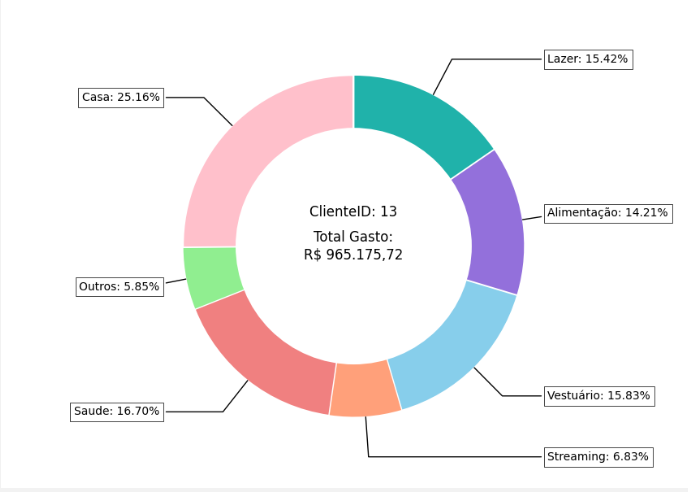